In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn.model_selection import KFold
from sklearn import linear_model
import math

%matplotlib inline
plt.style.use('seaborn-white')

## Lasso Overview

Least Absolute Shrinkage and Selection Operator

Objective Function:

$$ \begin{eqnarray}
\underset{\beta}{\mathrm{argmin}} RSS_{lasso} (\beta) &=& \frac{1}{n} \underset{\beta}{\mathrm{argmin}} (RSS_{OLS} (\beta) + \lambda |\beta|_{1} )\\
&=& \underset{\beta}{\mathrm{argmin}} \frac{1}{n} ||y - (\beta)X)||^{2}_{2} + \lambda |\beta|_{1} \\ 
&=& f(\beta) + g(\beta)
\end{eqnarray}$$

where $f(\beta)$ is the $RSS_{OLS}$ term, and $g(\beta)$ is the regularization factor for Lasso.

After applying some subdifferentials and subderivatives, we find that the Objective function becomes: 

$$ \begin{eqnarray}
\frac{\partial d}{\partial d \beta_{j}} RSS_{Lasso} + \partial \beta_{j} \lambda \sum^{n}_{j=0} |\beta_{j}|
&=& - \sum^{m}_{i=0} x_{j}^{i} (y^{i} - \sum^{n}_{k \ne j} \theta_{k} x_{k}^{i} ) + \theta_{j} \sum^{m}_{i=1} (x_{j}^{i})^{2} + \partial_{\beta_{j}} \lambda|\beta_{j}| \\ 
&=& - \rho_{j} +  \beta_{j} z + \partial_{\beta_{j}} \lambda|\beta_{j}| \\
\end{eqnarray}$$

Proposed strategy:
- Solve linear system via soft-thresholding with coordinate descent for given values of tuning parameter lambda.
- Tuning lambda via 4-fold Cross validation. k value with lowest mean MSE will be chosen. 

### Lasso from scratch begins here: 

1. The setup: design matrix and response variable (price).
2. Two functions: soft_thresholding and coordinate_descent_lasso are created. 
    - soft_thresholding: returns value of $\beta^{(LASSO)}_{j}$  based on values of the OLS solution $\hat{\beta_{j}^{(OLS)}}$. The process involves finding the first derivative of the LASSO objective function- in whihc the OLS solution is factorized into the product of normalization constant $z_{j}$ and $\rho$. The LASSO solution then becomes a piecewise solution based on the relative value of $\rho$ and $\lambda$: $\rho > lambda$, $\rho < -\lambda$, $-\lambda \le \rho \le \lambda$. soft_thresholding returns these piecewise solutions based on $\rho$ and $\lambda$ values.  

### Importing data and defining functions (soft_threshold, coordinate_descent_lasso, lambda_tune)

In [2]:
# returns piecewise soft_thresholding solution. rho is based on the coordinate-wise OLS solution

def soft_threshold(rho,lamda):
    '''Soft threshold function used for normalized data and lasso regression'''
    if rho < (-1 * lamda):
        return (rho + lamda)
    elif rho >  lamda:
        return (rho - lamda)
    else: 
        return 0

In [4]:
# returns the LASSO solution using coordinate descent 

def coordinate_descent_lasso(theta,X,y,lamda, num_iters=100):
    '''Coordinate gradient descent for lasso regression - for normalized data. 
    The intercept parameter allows to specify whether or not we regularize theta_0'''
    
    m,n = X_train.shape
    norm = np.linalg.norm(X_train,axis = 0)
    for i in range(n):
        if norm[i] != 0:
            X_train[:,i] = (X_train[:,i] - np.mean(X_train[:,i])) / np.std(X_train[:,i])

    #Looping until max number of iterations
    for i in range(100): 

        #Looping through each coordinate
        for j in range(n):

            #Vectorized implementation
            X_j = X_train[:,j].reshape(-1,1)
            y_pred = X_train @ theta
            y_pred = y_pred.reshape(-1,1)
            rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)
            rho = float(rho)

            #Checking intercept parameter

            theta[j] =  soft_threshold(rho, lamda) 
            
    return theta.flatten()

In [5]:
# Tunes lambda by 4-fold cross validation. Uses lambdas from 0.1 to 10 in increments of 0.1. 

def lambda_tune(X_train,y_train):
    
    all_mse = list() # 100 total entries (lambda), each entry has 4 entries (4-fold)
    lamda = np.arange(0.1,10,0.1) #Range of lambda values
    
    kf = KFold(n_splits = 3, random_state = True, shuffle = True)

    for l in lamda:                                             # Iterate through all lambda (200)
        mse_vals = list()
        
        for train_index, test_index in kf.split(X_train):       # Iterate through each of 10 folds for each lamda 
            temp_X_train = X_train[train_index]
            temp_y_train = y_train[train_index]
            temp_X_test = X_train[test_index]
            temp_y_test = y_train[test_index]
            
            n,p = temp_X_train.shape
            initial_theta = np.ones((p,1))
            MSE = 0

            theta = coordinate_descent_lasso(initial_theta,temp_X_train,temp_y_train,lamda = l, num_iters=100) # fit lasso model
            y_pred = temp_X_test @ theta                         # Predicted response values based on beta coefficients   
            
            for i in range(len(test_index)):
                MSE += (temp_y_test[i][0] - y_pred[i])**2
            MSE = MSE/n                                         # MSE of each of the 4 lasso models fitted to a given lambda 
            mse_vals.append(MSE)
        all_mse.append(mse_vals)
    return all_mse,lamda

In [6]:
# Import dataframe

#Loading in Data
df = pd.read_csv("../data/listings.csv")
df.drop(df.columns[0], axis=1, inplace=True)

In [8]:
# 80:20 split of our data 

from sklearn.model_selection import train_test_split
Y = df["price"]
X = df.drop("price", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train,y_train,X_test,y_test = X_train.to_numpy(),y_train.to_numpy(),X_test.to_numpy(),y_test.to_numpy()
y_train = y_train.reshape(-1,1)

In [9]:
# computes R^2 of our trained model.

def r2score(y_pred, y):
    rss = np.sum((y_pred - y) ** 2)
    tss = np.sum((y - y.mean()) ** 2)

    r2 = 1 - (rss / tss)
    return r2

### Fitting Lasso: (No intercept)

### Tuning Lambda
We conduct 10-fold cross validation:

1. Split training set into 10 partitions. (for each iteration: 9 partitions are used for training, 1 for testing) 
2. 10 lasso models are trained for 300 lambda values.
3. For each lambda value, find the mean MAE of the 10 lasso models. 
3. Select lambda = k that has lowest mean MAE.

In [40]:
# Returns a two numpy arrays of each lambda value and the mean MSE associated with it.
all_mse, lamda = lambda_tune(X_train,y_train) # lambda = 0.1 was the optimal lambda value.

In [105]:
# Fitting model on tuned lambda of 0.1

initial_theta = np.ones(231)
# Fitting Lasso on tuned lambda = 0.1241
import timeit
timestart = timeit.default_timer()           # start timer
theta = coordinate_descent_lasso(initial_theta,X_train,y_train,lamda = 0.1, num_iters=100)
timeend = timeit.default_timer()             # end timer
time_elapsed = (timeend - timestart) # calculate elapsed time

time_elapsed

<ipython-input-4-45a73418d0c9>:21: RuntimeWarning: overflow encountered in matmul
  y_pred = X_train @ theta
<ipython-input-4-45a73418d0c9>:21: RuntimeWarning: invalid value encountered in matmul
  y_pred = X_train @ theta
<ipython-input-4-45a73418d0c9>:23: RuntimeWarning: invalid value encountered in matmul
  rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)
<ipython-input-4-45a73418d0c9>:23: RuntimeWarning: overflow encountered in multiply
  rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)
<ipython-input-4-45a73418d0c9>:23: RuntimeWarning: invalid value encountered in add
  rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)
<ipython-input-4-45a73418d0c9>:23: RuntimeWarning: overflow encountered in matmul
  rho = X_j.T @ (y_train - y_pred  + theta[j]*X_j)


78.14610160000029

In [107]:
# run
theta = theta.reshape(-1,1)

# Computing MSE of our fitted LASSO model
y_pred = X_test@theta
SSE = 0
for i in range(11652):
    SSE += (y_test[i] - y_pred[i])**2
MSE = SSE/11652
RMSE = math.sqrt(MSE)

<ipython-input-107-d99a6dbc3aac>:8: RuntimeWarning: overflow encountered in square
  SSE += (y_test[i] - y_pred[i])**2


In [109]:
print(MSE)
print(RMSE)

[inf]
inf


### Implementation using sklearn (for comparison)

In [41]:
from sklearn import linear_model

In [42]:
# Initialize variables
m,n = X_train.shape
theta_list_sk = list()
lamda = np.arange(0.01,5,0.01) #Range of lambda values from 0.01 to 5 in increment: 0.01

# Run lasso regression for each lambda
for l in lamda:
    clf = linear_model.Lasso(alpha = l, fit_intercept = False)
    clf.fit(X_train,y_train)
    theta_list_sk.append(clf.coef_)

#Stack into numpy array
theta_lasso_sk = np.stack(theta_list_sk).T

C:\Users\kxu97\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e+07, tolerance: 1.629e+05
  model = cd_fast.enet_coordinate_descent(


In [51]:
# 4-fold cross validation

all_mae_sk, all_mse_sk, lamda = lambda_tune_SK(X_train,y_train,4)
allmeans = list()
for i in range(300):
    allmeans.append(np.mean(all_mae_sk[i]))

min_index = allmeans.index(min(allmeans))
lamda[min_index] # 0.1240639159058832

0.1240639159058832

No handles with labels found to put in legend.


(0.0687528918396024, 261.1497606350303, 2255.3286925025554, 51158.17394579791)

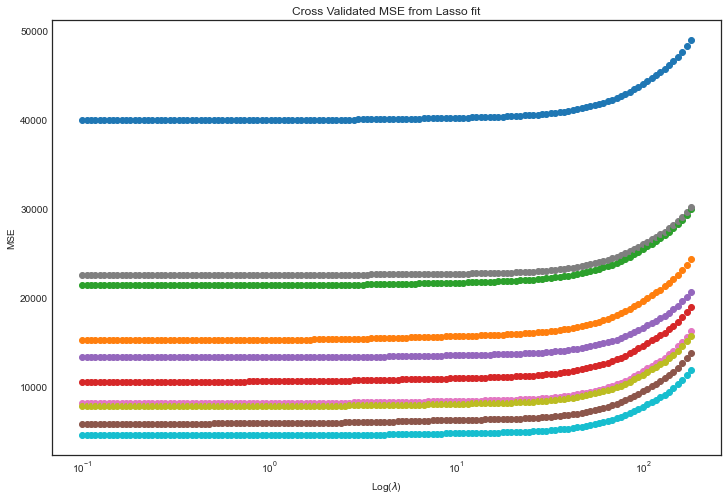

In [290]:
# Plotting MSE against lamda (sk-lasso model)

n = 300
plt.figure(figsize = (12,8))

for i in range(140):
    for j in range(10):
        plt.scatter(lamda[i], all_mse_sk[i][j])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('MSE')
plt.title('Cross Validated MSE from Lasso fit')
plt.legend()
plt.axis('tight')

In [265]:
# Finding the minimum lamda value
allmeans = list()
for i in range(300):
    allmeans.append(np.mean(all_mse_sk[i]))

min_index = allmeans.index(min(allmeans))
lamda[min_index]

0.1

## Generating final model 
- Recap: 
    - Hyperparameter tuning: 
        - Coordinate_descent: lambda = 24244 (minimum MSE & minimum MAE) 
        - Sk_lasso: lambda = 16.75252472408214 (MAE), lambda = 0.1 (MSE)
    - Lasso model without intercept is chosen because of strange lasso path that has increasing beta value.
    
 - SK_Lasso Model: 5 variables: 
     - availability_365, 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'room_type_Entire home/apt', 'room_type_Private room'.
     - $$y = 17.21323117 X_{availability365} + 2.6954145 X_{neighbourhoodgroup(Brooklyn)} + 27.00013305 X_{neighbourhoodgroup(Manhattan)} + 68.55946047 X_{roomtype(home/apt)} + 14.12280336 X_{roomtype(Private room)} + \epsilon$$ with $\epsilon$: noise term, and $\lambda = 16.75252472408214$ tuned from minimium MAE
 - Coordinate_descent Model: 1 variable: 
     - $y = 909.26194755 X_{room_type_Private room} + \epsilon$ with $\lambda = 24244$

In [50]:
from sklearn.linear_model import LassoCV
SSE = 0
MSE = 0
reg = LassoCV(cv=4, random_state=0).fit(X_train, y_train)
y_pred = reg.predict(X_test)
for i in range(len(y_test)):
    SSE += (y_test[i] - y_pred[i])**2
MSE = SSE/len(y_test)
MSE
#print(reg.score(X_test, y_test))

C:\Users\kxu97\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


13551565.040087348

In [51]:
#RMSE of sk-learn LASSO fitting
math.sqrt(MSE)

3681.2450393973163

In [56]:
clf = linear_model.Lasso(alpha= 0.1240639159058832 , fit_intercept = False)
clf.fit(X_train,y_train)
coefs = np.array(clf.coef_)

In [63]:
# Beta coefficient and associated variable of our LASSO solution (sklearn fitting)

count = 0
for i in range(len(coefs)):
    print(coefs[i],cols[i])
    if coefs[i] == 0:
        count+=1
count

-5.245707641144252 minimum_nights
-9.142105366564714 number_of_reviews
0.44993744622768894 reviews_per_month
-2.6387289304227344 calculated_host_listings_count
23.541270007059275 availability_365
-3.575290348231469 neighbourhood_group_Bronx
0.0 neighbourhood_group_Brooklyn
27.76831604079182 neighbourhood_group_Manhattan
-3.9825188759997787 neighbourhood_group_Queens
-3.3815150703108996 neighbourhood_group_Staten Island
0.0 neighbourhood_Allerton
-0.18592459315219903 neighbourhood_Arden Heights
-0.04394281969456824 neighbourhood_Arrochar
1.1213649826019239 neighbourhood_Arverne
1.2009071700173701 neighbourhood_Astoria
-0.7715411502689357 neighbourhood_Bath Beach
0.16393618757248252 neighbourhood_Battery Park City
-1.1304125401925 neighbourhood_Bay Ridge
0.03586007407216758 neighbourhood_Bay Terrace
0.0 neighbourhood_Bay Terrace, Staten Island
-0.10717515367259957 neighbourhood_Baychester
2.9607703983608284 neighbourhood_Bayside
-0.00036706858693948304 neighbourhood_Bayswater
-0.45905373

41

In [62]:
# The variable with highest magnitude coefficient is printed.
# The top 5 variables and their coefficient values are commented below.

print(coefs[np.argmax(coefs)],cols[np.argmax(coefs)])

#1. room_type_Entire home/apt:: 47.18672936847277
#2. 27.76831604079182 neighbourhood_group_Manhattan\
#3. 15.432100035669894 neighbourhood_Tribeca
#4. 12.467952723016737 neighbourhood_Midtown
#5. -9.142105366564714 number_of_reviews
#6. -8.56804453631664 neighbourhood_Harlem

47.18672936847277 room_type_Entire home/apt


In [64]:
# Number of variables remaining after dimension reduction

231-41

190

In [70]:

# Computing MSE of our fitted LASSO model
y_pred = X_test@coefs
SSE = 0
for i in range(11652):
    SSE += (y_test[i] - y_pred[i])**2
MSE = SSE/11652
RMSE = math.sqrt(MSE)

In [71]:
RMSE

3729.2527489804756

In [74]:
import numpy
 
corr_matrix = numpy.corrcoef(y_test, y_pred)
corr = corr_matrix[0,1]
R_sq = corr**2
 
print(R_sq)

0.0066953704133738325


In [75]:
adj = 1 - ((1 - R_sq)*(len(y_test) - 1)) / (len(y_test) - 231 - 1)

In [76]:
adj

-0.013396868591399436

In [77]:
len(y_test)

11652